In [1]:
import joblib

import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2
from scipy.signal import convolve2d
from scipy import stats
from skimage.measure import label
from skimage.transform import rotate
from imutils import contours
import sklearn
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [2]:
import matplotlib.pyplot as plt 

def show(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [3]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, "rb") as file:
    pickle_model = pickle.load(file)

/home/iana/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:


def get_gaussian_kernel(size=17, nsig=3):
    x = np.linspace(-nsig, nsig, size + 1)
    kernel_1D = np.diff(stats.norm.cdf(x))
    
    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D_norm = kernel_2D / kernel_2D.sum()
    
    return kernel_2D_norm

In [5]:
def harris_theta(image, alpha=0.05, kernel_size=17):
    gx, gy = np.gradient(image)
    
    # outer product elements
    gxx = gx ** 2
    gyy = gy ** 2
    gxy = gx * gy
    
    kernel = get_gaussian_kernel(kernel_size)
    
    # matrix M components
    mxx, myy, mxy = [convolve2d(x, kernel, mode='same') for x in [gxx, gyy, gxy]]
    
    theta = (
        mxx * myy - mxy ** 2 # det
        - alpha *
        (mxx + myy) ** 2 # trace
    )
    
    return theta


   
def get_corners_indices(theta, threshold):
    components = label(theta > threshold)
    labels = np.unique(components)
    labels = labels[1:] # drop the background
    
    indices = []
    for component in labels:
        comp_mask = components == component

        idx = np.argmax(theta * comp_mask)

        # argmax returns a flat index, so make id 2D:
        idx = np.unravel_index(idx, theta.shape)
        indices.append(idx)

    indices = np.array(indices)

    ys, xs = indices.T
    return ys, xs

In [6]:
def contour_filter(contours, hierarchy, minArea):
    cnts1 = []
    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) > minArea:
            cnts1.append(contours[i])
    return cnts1

# Detect contours 
def detect_contours(img, minArea):
    contours, hierarchy = cv2.findContours(img,
                                            cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_SIMPLE)

    cnts = contour_filter(contours, hierarchy, minArea)

    #draw contours
    cv2.drawContours(img, cnts, -1, (255,0,0), 3) 
    cv2.imwrite('cnts.png', img)
    return cnts, hierarchy, img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

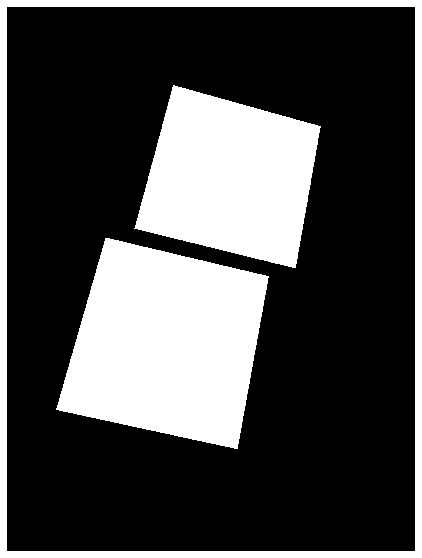

In [33]:
def img_proccess(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((9,9),np.uint8)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(3,3),0)
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
    ret,th = cv2.threshold(th,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_inv = 255 - th.astype(np.uint8)
    img_th = cv2.morphologyEx(img_inv, cv2.MORPH_CLOSE, kernel, borderType=cv2.BORDER_CONSTANT)
    return img_th


def get_mask(img, img_th):
    kernel = np.ones((5,5),np.uint8)
    cnts = detect_contours(img_th, 35000)[0]
    cordinates = []
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        cordinates.append((x,y,w,h))
        #bounding the images
        
            
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),4)

    # initialize a contour that corresponds to the puzzle outline
    puzzleCnt = []
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we can
        # assume we have found the outline of the puzzle
        if len(approx) == 4:
            puzzleCnt.append(approx)
            
        
    mask = np.zeros((img_th.shape[0], img_th.shape[1]))
    mask = cv2.fillPoly(mask, puzzleCnt, 255)

    show(mask/255)
    return mask/255
    
img = cv2.imread('train_2.jpg')
img_th = img_proccess(img)
get_mask(img, img_th)

In [8]:
def normalized (img):
    
    cnts = detect_contours(img, 35000)[0]
    areas = []
    index = []
    i = 0
    for cnt in cnts:
        areas.append(cv2.contourArea(cnt))
        index.append(i)
        i+=1
    area_dict = dict(zip(index, areas))
    areas = np.sort(areas)
    def get_key(d, value):
        for k, v in d.items():
            if v == value:
                return k
    rect = cv2.minAreaRect(cnts[get_key(area_dict, areas[-1])])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    perimeter = cv2.arcLength(cnts[get_key(area_dict, areas[-1])], True) 
    epsilon = 0.01 * perimeter
    approx = cv2.approxPolyDP(cnts[get_key(area_dict, areas[-1])],epsilon,True)
    if approx.shape[0] == 4:
        box = approx.reshape(4,-1)
    rect = np.zeros((4, 2), dtype = "float32")
    s = box.sum(axis = 1)
    rect[0] = box[np.argmin(s)]
    rect[2] = box[np.argmax(s)]
    diff = np.diff(box, axis = 1)
    rect[1] = box[np.argmin(diff)]
    rect[3] = box[np.argmax(diff)]
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    return warped



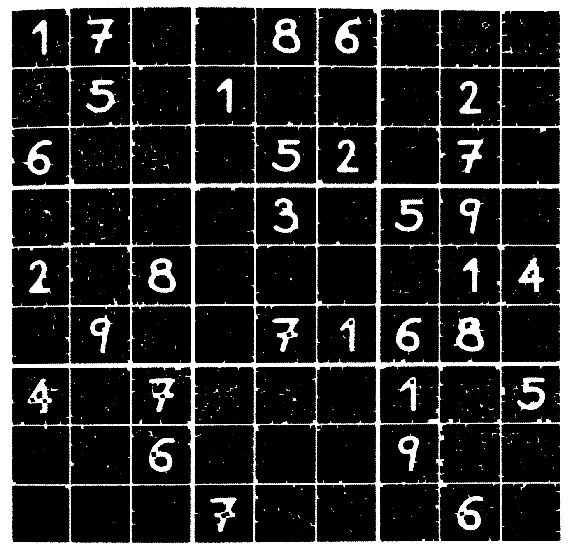

In [34]:

show(normalized(img_th))


In [41]:
def find_cells(img):
    """
    Find the cells of a sudoku grid
    """
    img_area = img.shape[0] * img.shape[1]

    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Array containing the cropped cell image and its position in the grid
    cells = []
    for c in contours:
        area = cv2.contourArea(c)

        # Approximate the contour in order to determine whether the contour is a quadrilateral
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.017 * peri, True)

        # We are looking for a contour of a specific area in relation to the grid size
        # and that is roughly quadrilateral
        # We filter for areas that are too small or too large in relation to the whole image
        if area / img_area > 0.0001 and area / img_area < 0.02 and len(approx) == 4:
            # Using masking, we crop the cell into its own 28 by 28 pixel image
            mask = np.zeros_like(img)
            cv2.drawContours(mask, [c], -1, 255, -1)

            (y, x) = np.where(mask == 255)

            (top_y, top_x) = (np.min(y), np.min(x))
            (bottom_y, bottom_x) = (np.max(y), np.max(x))
            cell = img[top_y : bottom_y + 1, top_x : bottom_x + 1]

            cell = cell.copy()
            cell = cv2.resize(cell, (28, 28))

            # We also find the centroid of the cell in relation
            # to the grid
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            cells.append(({"img": cell, "pos": (cX, cY)}))
   
    return cells

cells = find_cells(normalized(img_th))

cells

[{'img': array([[165,   0,   0,   1,  27,   0,   0,   0,   0,   0,   0,  27,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,
          255, 255],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            3, 255],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0, 215],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,  63],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0],
         [ 10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [42]:
def find_cell_values(cells):
    """
    Using a k-nearest neighbours classifier trained on sudoku cells,
    determine the value of each cell in the provided cell array.
    """
    cells_with_value = []
    for cell in cells:
        y_pred = pickle_model.predict([cell["img"].flatten()])[0]
        cells_with_value.append({"pos": cell["pos"], "value": y_pred})

    return cells_with_value

cells = find_cell_values(cells)
cells

[{'pos': (94, 1245), 'value': 8},
 {'pos': (239, 1244), 'value': 8},
 {'pos': (387, 1243), 'value': 8},
 {'pos': (540, 1241), 'value': 5},
 {'pos': (688, 1240), 'value': 8},
 {'pos': (837, 1238), 'value': 8},
 {'pos': (990, 1236), 'value': 8},
 {'pos': (1138, 1234), 'value': 2},
 {'pos': (93, 1102), 'value': 8},
 {'pos': (239, 1101), 'value': 8},
 {'pos': (385, 1100), 'value': 2},
 {'pos': (688, 1096), 'value': 8},
 {'pos': (836, 1094), 'value': 8},
 {'pos': (1284, 1089), 'value': 8},
 {'pos': (92, 959), 'value': 2},
 {'pos': (237, 958), 'value': 8},
 {'pos': (385, 956), 'value': 6},
 {'pos': (539, 954), 'value': 8},
 {'pos': (687, 952), 'value': 8},
 {'pos': (835, 951), 'value': 8},
 {'pos': (987, 949), 'value': 6},
 {'pos': (1135, 948), 'value': 8},
 {'pos': (90, 812), 'value': 8},
 {'pos': (236, 810), 'value': 6},
 {'pos': (384, 808), 'value': 8},
 {'pos': (538, 806), 'value': 8},
 {'pos': (687, 805), 'value': 6},
 {'pos': (835, 803), 'value': 8},
 {'pos': (987, 802), 'value': 2},
 

In [43]:
def get_sudoku_grid(cells):
    """
    Given a list of cells and they position, return a 2D array representing
    a sudoku grid, where each element of this 2D array contains of the value of the grid
    at that position.
    """
    cells.sort(key=lambda cell: cell["pos"][0])

    cells_X = []
    i = 0
    for cell in cells:
        cells_X.append(
            {"pos": cell["pos"], "value": cell["value"], "columnIndex": int(i / 9)}
        )
        i += 1

    cells_X.sort(key=lambda cell: cell["pos"][1])

    cells_in_grid = []
    i = 0
    for cell in cells_X:
        cells_in_grid.append(
            {
                "pos_in_grid": (cell["columnIndex"], int(i / 9)),
                "value": cell["value"],
                "pos": cell["pos"],
            }
        )
        i += 1

    grid = np.zeros((9, 9))
    grid_meta = np.zeros((9, 9, 3))
    for cell in cells_in_grid:
        grid[cell["pos_in_grid"][1], cell["pos_in_grid"][0]] = cell["value"]
        # We keep some info about the grid: centroid of each cell, and whether it is blank
        grid_meta[cell["pos_in_grid"][1], cell["pos_in_grid"][0]] = [
            cell["pos"][0],
            cell["pos"][1],
            cell["value"] == 0,
        ]

    return grid, grid_meta

In [44]:
grid = get_sudoku_grid(cells)
grid[0]

array([[6., 6., 8., 8., 0., 8., 8., 0., 0.],
       [8., 8., 8., 5., 5., 8., 5., 8., 0.],
       [2., 8., 8., 5., 8., 5., 6., 8., 0.],
       [8., 8., 8., 8., 8., 8., 8., 2., 0.],
       [6., 0., 8., 8., 6., 8., 2., 8., 0.],
       [8., 8., 6., 8., 8., 8., 6., 0., 0.],
       [8., 8., 2., 0., 8., 8., 8., 2., 0.],
       [8., 8., 8., 5., 8., 8., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def predict_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sudoku_digits = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1,  8,  9,  4, -1, -1, -1],
                  [-1, -1, -1,  6, -1,  1, -1, -1, -1],
                  [-1,  6,  5,  1, -1,  9,  7,  8, -1],
                  [-1,  1, -1, -1, -1, -1, -1,  3, -1],
                  [-1,  3,  9,  4, -1,  5,  6,  1, -1],
                  [-1, -1, -1,  8, -1,  2, -1, -1, -1],
                  [-1, -1, -1,  9,  1,  3, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]